# Fine-tuning

- 다양한 pretrained networks를 활용한 실험

- <span style='color:red'>주의사항</span>
    - 현재 설치되어있는 cuda 버전이 11.0이라서, 파이토치 1.7.1 버전까지만 설치가 가능하다.
    - cuda 버전을 바꾸어도 될 지 확인해보아야겠다.

In [3]:
from IPython.display import Image

## 실험 1: ResNet-18
- 데이터의 수가 많지 않기 때문에, pretrained된 resnet 18 모델을 활용한다.
- resnet은 imagenet 데이터로 학습되었는데, 대회 데이터인 마스크 데이터셋과는 차이가 있기 때문에
resnet 또한 최적화한다.
- 결과적으로 resnet18을 backbone으로 설정하고, classifier를 basemodel로 만든 뒤 학습시킨다.

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_test",
}
```

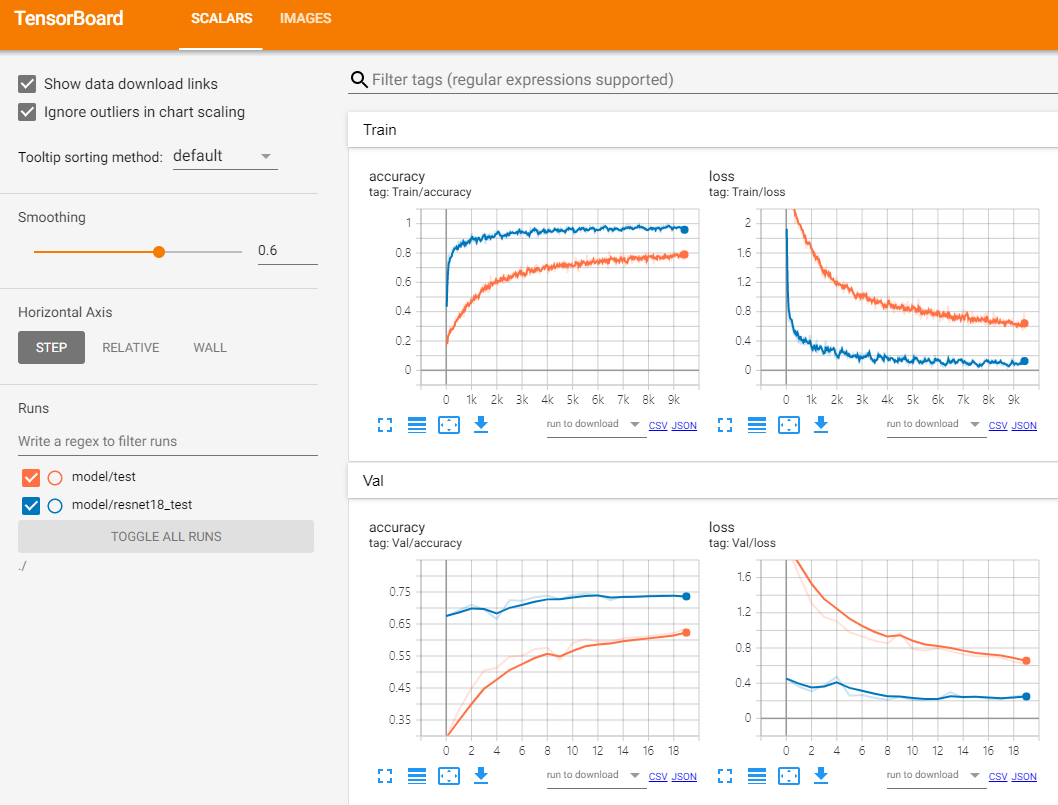

In [3]:
Image(filename="/opt/ml/experiment-results/v3_resnet18.PNG")

**[변경사항]**
- 비교군: baseline_v2의 exp8, resent18
- resnet18의 마지막 fc layer를 1000 -> 18(=num_classes)로 변경하였음.

**[결과]**
- baseline_v2에서 가장 좋은 성능을 보이는 모델과 비교했을 때, validation accuracy 기준 10% 가량의 성능 향상이 나타났다.
- 제출했을 때, test acc 기준 10% 가량의 성능 향상이 나타났다.

**[분석]**
- 우선 데이터의 수가 적기 때문에 resnet18 모델로도 충분한 표현력을 가질 수 있다고 생각했고, baseline_v2와 비교했을 때 꽤나 성능이 향상되었다.
- 다만 training acc와 val acc를 비교했을 때 차이가 심했고, 이는 overfitting을 의심할 수 밖에 없었다.
    - 20 에폭 밖에 돌리지 않았음에도 training acc 기준 95% 까지 달성했고, val acc는 73% 정도 찍혔다.
    - val acc에 비해서 training acc만 비정상적으로 높았던 것을 보아, overfitting이 의심된다.
    - 다만 training data에 overfitting이 일어났던 점은 data의 수가 너무 적었기 때문이라고 생각한다.
    - 또한 training data와 val data를 split할 때, class의 분포는 고려하지 않은 채로 나누었기 때문에 이러한 현상이 심화되었다고 생각한다.
- ImageNet의 모든 데이터를 알 수는 없지만, 사람의 얼굴 혹은 마스크를 착용한 사람의 얼굴 데이터는 거의 없을 것으로 생각한다.
    - 다만 종류가 다른 데이터라고 해도, randomly initialized weight 보다는 pretrained weight가 성능 측면에서 좋기도 하고, 또한 모든 parameters를 tuning했기 때문에 최소한의 성능은 나타난 것으로 보여진다.

**[계획]**
- fold 방식을 이용해서, 학습에 사용할 수 있는 데이터를 최대한 활용하는 방식으로 접근한다.
- train/validation split을 클래스 간 분포가 어느 정도 맞게 분리해본다.

## 실험 2: ResNet-18 with original resnet input size(224 x 224)
**[계획]**
- pretrained network를 사용할 때 정말 중요한 것은, 해당 모델을 학습시킬 때의 방식을 동일하게 가져가는 것이다.
- 대표적으로는 입력 이미지의 사이즈가 있고, 이미지를 normalize하는 수치 또한 중요할 수 있다.
- 일단은 이미지 사이즈를 원래 resnet paper의 224 x 224로 resize해준 뒤 학습을 시켜보았다.


```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [ # caution!
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_imagenetsize",
    "data_dir": "/opt/ml/input/data/train/images",
    "model_dir": "./model"
}
```

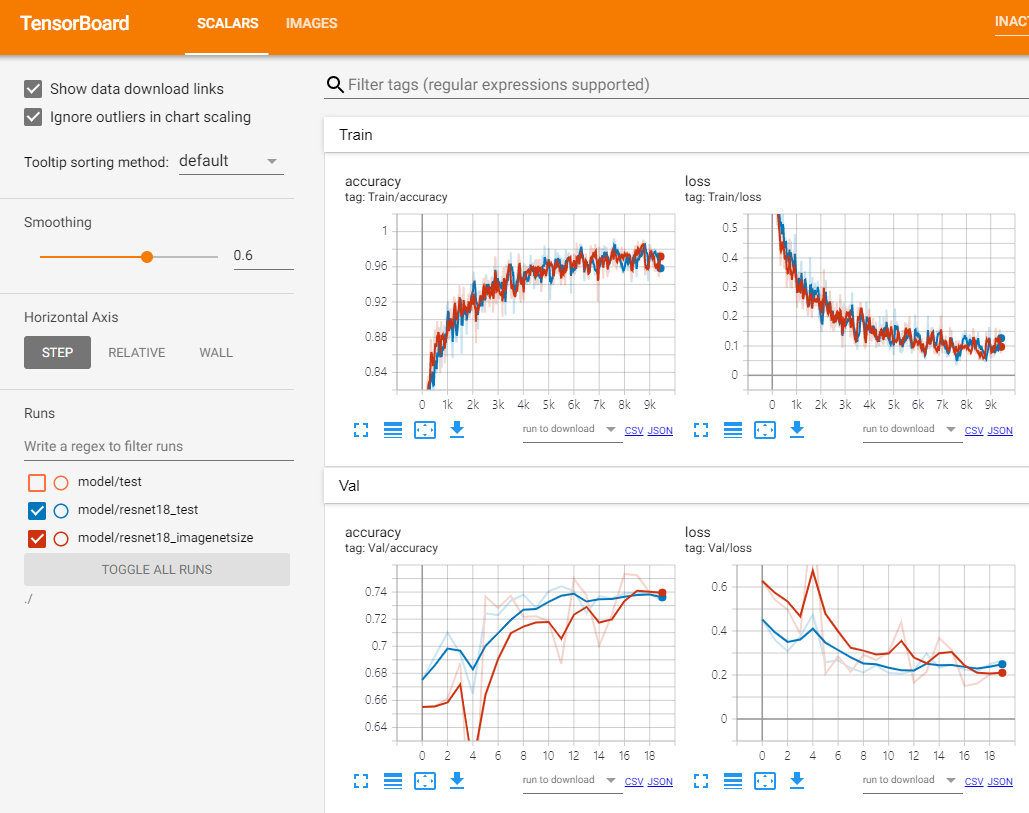

In [5]:
Image(filename="/opt/ml/experiment-results/resnet18/v3_resnet18_224by224.PNG")

**[변경사항]**
- 비교군: resnet18, resnet18 with 224 x 224 size
- resnet18에 입력되는 이미지 사이즈를 128 x 96에서 224 x 224로 변경하였음.

**[결과]**
- resnet18과 비교했을 때 val acc가 1% 정도 높았다.
- 재밌었던 사실은 submission을 했을 때 resnet18보다 f1은 0.5, accuracy는 6% 가량 향상되었다는 점이었다.

**[분석]**
- 첫 번째로 눈에 띄는 차이점은, train/val 모두 acc/loss 측면에서 <span style='color:lightblue'>oscillation(진동)이 많이 발생했다</span>는 점이다.
    - 아무래도 입력 이미지의 크기가 훨씬 커졌으니(3 x 224 x 224 - 3 x 128 x 96 = 113,664. 한 장의 이미지 당 11만 개의 추가 픽셀 정보가 생긴 것),
    보다 학습이 불안정했던 것이 아닐까 생각한다.
- training acc와 val acc가 같이 상승하는 모습이긴 하지만, training acc는 95%에 달하는 정확도를 보이는 반면에 val acc는 70% 중반 정도를 보인다는 것은,
overfitting이라고도 해석가능하지만 이보다는 <span style='color:orange'>training data와 validation data 간의 클래스 불균형</span>이 일어났다고 해석할 수 있다.
    - train/val dataset을 단순히 80:20으로 나누기 때문에, 클래스의 분포가 고르게 되어있지 않다.
    - train/val dataset의 클래스 분포가 유사하지 않다면, 위 그래프와 같이 training acc는 비정상적으로 높고 val acc는 낮게 나올 수 있다.
    결국 모델은 train data로부터 얻은 gradient로 최적화되기 때문에, train에 없는 data들이 val에 많다면 val acc가 낮을 수 밖에 없다.
    - train/val의 클래스 분포가 유사하도록 data를 split해야 한다.
- 성능이 높아진 이유로는, 확실하진 않지만 2가지 정도 떠오른다.
    - 첫 번쨰는 정보가 많아졌다는 점이다(이는 어느정도 확실한 것 같다).
    - 두 번째는 pretrained resnet18 모델이 224 x 224 사이즈의 이미지로 학습된 모델이기 때문에, 동일한 모양을 가지는 이미지를 입력받았을 때
    기존 학습되어있던 정보를 보다 잘 활용할 수 있었겠다고 생각한다(불확실하다).

**[계획]**
- fold 방식을 이용해서, 학습에 사용할 수 있는 데이터를 최대한 활용하는 방식으로 접근한다.
- train/validation split을 클래스 간 분포가 어느 정도 맞게 분리해본다.
- 원본 이미지를 바로 224 x 224로 resize하지 말고, centercrop과 같은 preprocessing을 거쳐 유의미한 정보만 추출한 뒤 resize해본다.
- Adam을 쓰니 너무 빠르게 수렴하는 것 같은데, 대회 게시판에 다른 캠퍼분이 올려주신 것을 보니 보다 단순한 optimizer를 써보아도 좋을 것 같다.

## 실험 3: ResNet-18 with reduced LR
**[계획]**
- 학습 과정의 그래프를 보았을 때 진동이 많이 발생하는 것 같아서, learning rate를 1/10로 줄여 보다 안정적으로 학습이 이루어지게끔 한다.

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.0001,   # 0.001 -> 0.0001로 변경
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_originalsize_reducelr",
}
```

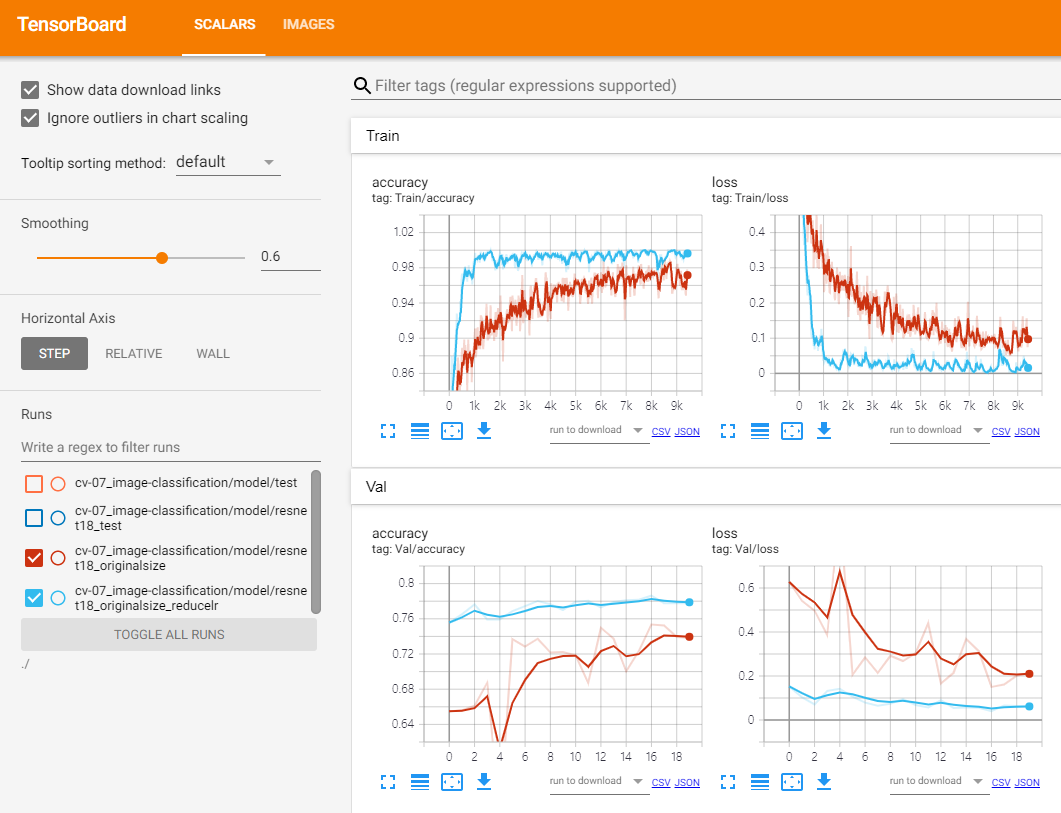

In [4]:
Image(filename="/opt/ml/experiment-results/resnet18/v3_resnet18_reducelr.PNG")

**[변경사항]**
- 비교군: resnet18 with 224 x 224 size, resnet18 with 224 x 244 and lr=0.0001
- resnet18의 parameters를 최적화하는 Adam의 learning rate를 0.001 에서 0.0001로 1/10만큼 감소시켰음.

**[결과]**
- learning rate를 1/10 감소시켰을 때 train/val loss/acc 측면에서 큰 성능 향상이 일어났다.
- submission 결과 f1 score는 0.05 정도, acc는 4% 정도 향상되었다.
- 학습 초기부터 수렴하는 모습을 보여주었으며, 특이사항으로는 <span style='color:orange'>training acc가 100%</span> 였다는 점이다.

**[분석]**
- train/val data 모두에 수렴하는 모습을 보여주었으나, 그래프를 보면 알 수 있듯이 val acc/loss는 saturation되는 모습이 나타난다.
    - 이는 앞선 실험에서 언급했던 <span style='color:orange'>train/val data 간의 클래스 분포 불균형</span>때문이라고 해석가능하다.
    - 모델은 train data를 기반으로 최적화되기 때문에 train data를 잘 맞출 수 있도록 최적화된다.
    - 만약 val data의 분포가 train data와 유사하다면, val acc/loss 역시 train acc/loss의 양상을 따라가야 한다.
    - 하지만 val data에 대한 모델의 예측 성능은 saturation된 모습이고, 이는 train/val data가 서로 다르다고 해석가능하다(train data에 없는 data들이 val data에 많다는 것).
    - 실험 세팅을 더 이상 변경하지 않아도, 데이터 split만 균형있게 한다면 모델의 일반화 성능이 높아질 것으로 예상한다.
- Adam 기준 lr을 0.0001로 세팅했을 때 상당히 수렴이 잘 되는 모습이다.
    - 이전 실험의 lr은 모델을 완전히 최적화하기에는 너무 큰 값이었을 수 있겠다.
    - 따라서 아키텍처가 변경되지 않는다면, 이후 resnet18 실험은 lr을 0.0001로 고정하고 실험해볼까 한다.

**[계획]**
- 모델의 성능은 f1 score로 평가되는데, f1 score를 어떻게 하면 올릴 수 있을지 metric을 분석해볼 생각이다.

## Metric: F1 Score

## 실험 4: ResNet-18 with K-Fold strategy
**[계획]**
- 앞선 실험으로, training data에는 overfitting 되었지만 validation data에 대해서는 낮은 성능을 보인다는 결과를 확인했다.
- 이는 현재 split 방식이, 사용자가 지정한 val_ratio에 맞게 random으로 분리하고 있기 때문이다.
    - random이긴 하지만 seed를 설정했기 때문에, seed 값을 변경하지 않는 이상 똑같은 train/val data로 분리한다.
- 이러한 문제점을 해소하기 위해서, 데이터가 한정적일 때 모든 데이터를 학습에 활용하면서도 모델 성능을 평가할 수 있는 fold stategy를 사용해본다.
- fold에는 k-fold, stratified-fold, group-fold 등이 있다. 일반적으로 imbalanced data에 대해서는 stratified-fold가 좋지만, k-fold부터 차례대로 실험하면서 실제 효과를 확인해보는 것이 목적이다.